In [1]:
import os
import random
from collections import defaultdict
from typing import Iterable, Sized

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models

from tqdm import tqdm
from torch import optim
from torchvision.models import ResNeXt50_32X4D_Weights
from torchvision.transforms.functional import resize
from torch.utils.data import DataLoader

from helpers.datasets import custom_collate_proposals_fn, CrackDatasetForClassificationWithProposals
from helpers.early_stopping import EarlyStopping

In [2]:
class Resnext50BasedClassifierForProposals(nn.Module):
    def __init__(
            self,
            input_shape: tuple[int, int, int] = (3, 224, 224),
            linear_layers_features: int = 512
    ):
        super().__init__()

        self.feature_extractor = models.resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.DEFAULT)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self._get_feature_size(input_shape), linear_layers_features),
            nn.ReLU(inplace=True),
            nn.Linear(linear_layers_features, linear_layers_features),
            nn.ReLU(inplace=True),
            nn.Linear(linear_layers_features, 1)
        )

        for param in self.feature_extractor.parameters():
            param.requires_grad = False

    def _get_feature_size(self, shape):
        with torch.no_grad():
            dummy_input = torch.zeros(1, *shape)
            features = self.feature_extractor(dummy_input)

            return features.numel()

    def forward(self, x):
        features = self.feature_extractor(x)
        class_scores = self.classifier(features)

        return class_scores

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
proposal_cache = defaultdict(list)
SELECTIVE_SEARCH_BATCH_SIZE = 70


def perform_selective_search(image: np.ndarray, image_path: str, batch_size: int = SELECTIVE_SEARCH_BATCH_SIZE) -> torch.Tensor:
    if image_path in proposal_cache:
        random.shuffle(proposal_cache[image_path])
        
        return torch.tensor(proposal_cache[image_path], dtype=torch.float32)
    else:
        ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

        ss.setBaseImage(image)
        ss.switchToSelectiveSearchFast()

        rects = ss.process()
        boxes = []
        image_area = image.shape[0] * image.shape[1]

        for (x, y, w, h) in rects:
            area = w * h
            
            if area == image_area:
                continue
            
            boxes.append((x, y, x + w, y + h, area))

        boxes = sorted(boxes, key=lambda b: b[4], reverse=True)
        boxes = [(x1, y1, x2, y2) for x1, y1, x2, y2, area in boxes]
        num_proposals = min(len(boxes), 2 * batch_size)
        top_proposals = boxes[:num_proposals]

        random.shuffle(top_proposals)

        proposal_cache[image_path] = top_proposals

        return torch.tensor(top_proposals, dtype=torch.float32)

In [5]:
def get_loaders() -> tuple[DataLoader, DataLoader]:
    train_images_dir = os.path.join("data", "train", "images")
    valid_images_dir = os.path.join("data", "valid", "images")
    train_coco_path = os.path.join("data", "train", "coco_annotations.json")
    valid_coco_path = os.path.join("data", "valid", "coco_annotations.json")
    train_dataset = CrackDatasetForClassificationWithProposals(
        perform_selective_search,
        train_coco_path,
        train_images_dir
    )
    valid_dataset = CrackDatasetForClassificationWithProposals(
        perform_selective_search,
        valid_coco_path,
        valid_images_dir
    )
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        collate_fn=custom_collate_proposals_fn
    )
    valid_dataloader = DataLoader(
        valid_dataset,
        batch_size=32,
        shuffle=True,
        collate_fn=custom_collate_proposals_fn
    )

    return train_dataloader, valid_dataloader

In [6]:
def get_loop_objects() -> tuple[Resnext50BasedClassifierForProposals, EarlyStopping, torch.nn.BCEWithLogitsLoss, optim.Adam]:
    model = Resnext50BasedClassifierForProposals()
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    early_stopping = EarlyStopping(patience=5, verbose=True, delta=0)

    model.to(device)

    return model, early_stopping, criterion, optimizer

In [7]:
num_epochs = 25
checkpoint_path = os.path.join("checkpoints", f"resnext50_32x4d_classifier_with_proposals.pt")
train_loader, valid_loader = get_loaders()
model, early_stopping, criterion, optimizer = get_loop_objects()
history = {
    "train_loss": [],
    "valid_loss": []
}
valid_accuracy = 0


def chunkify(x: Iterable | Sized) -> Iterable[Iterable]:
    for i in range(0, len(x), SELECTIVE_SEARCH_BATCH_SIZE):
        yield x[i:i + SELECTIVE_SEARCH_BATCH_SIZE]


def process_and_calculate_loss(
        image: torch.Tensor, 
        proposals: torch.Tensor, 
        labels: Iterable[int]
) -> tuple[torch.Tensor, int, int]:
    cropped_proposals_with_labels = []

    for idx, proposal in enumerate(proposals):
        label = labels[idx]
        x_min, y_min, x_max, y_max = proposal.int()
        cropped_region = image[:, y_min:y_max, x_min:x_max]
        resized_region = resize(cropped_region, [224, 224])

        cropped_proposals_with_labels.append((label, resized_region))

    batch_loss = 0.0
    correct = 0
    total = 0

    for chunk in chunkify(cropped_proposals_with_labels):
        labels_batch, proposals_batch = zip(*chunk)
        labels_batch = torch.stack(labels_batch).to(device)
        regions = torch.stack(proposals_batch).to(device)
        predictions = model(regions).squeeze(1)
        loss = criterion(predictions, labels_batch)
        batch_loss += loss.item()

        if model.training:
            loss.backward()

        predicted = (predictions > 0.5).float()
        correct += (predicted == labels_batch).sum().item()
        total += labels_batch.numel()

    return batch_loss, correct, total


for epoch in range(num_epochs):
    model.train()

    train_loss = 0.0
    correct_train = 0
    total_train = 0
    epoch_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")

    for images_group, proposals_group, labels_group in epoch_progress:
        optimizer.zero_grad()

        for image, proposals, labels in zip(images_group, proposals_group, labels_group):
            batch_loss, correct, total = process_and_calculate_loss(image, proposals, labels)

            train_loss += batch_loss
            correct_train += correct
            total_train += total

        optimizer.step()

        epoch_progress.set_postfix(loss=train_loss / total_train, accuracy=100. * correct_train / total_train)

    model.eval()

    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0

    with torch.no_grad():
        for images_group, proposals_group, labels_group in valid_loader:
            for image, proposals, labels in zip(images_group, proposals_group, labels_group):
                batch_loss, correct, total = process_and_calculate_loss(image, proposals, labels)
                valid_loss += batch_loss
                correct_valid += correct
                total_valid += total

    valid_accuracy = 100. * correct_valid / total_valid
    avg_valid_loss = valid_loss / total_valid

    history["train_loss"].append(train_loss / total_train)
    history["valid_loss"].append(avg_valid_loss)
    print(f"Validation Loss: {avg_valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.2f}%")
    early_stopping(avg_valid_loss, model, checkpoint_path)

    if early_stopping.early_stop:
        print("Early stopping triggered")
        break


Epoch 1/25: 100%|██████████| 295/295 [1:23:05<00:00, 16.90s/batch, accuracy=62.8, loss=0.0108]


Validation Loss: 0.0108, Validation Accuracy: 65.80%
Validation loss decreased (inf --> 0.010791).  Saving model ...


Epoch 2/25: 100%|██████████| 295/295 [40:15<00:00,  8.19s/batch, accuracy=64.1, loss=0.0104]


Validation Loss: 0.0122, Validation Accuracy: 65.76%
EarlyStopping counter: 1 out of 5


Epoch 3/25: 100%|██████████| 295/295 [40:07<00:00,  8.16s/batch, accuracy=64.6, loss=0.0102]


Validation Loss: 0.0123, Validation Accuracy: 65.02%
EarlyStopping counter: 2 out of 5


Epoch 4/25: 100%|██████████| 295/295 [40:04<00:00,  8.15s/batch, accuracy=64.8, loss=0.0101]


Validation Loss: 0.0106, Validation Accuracy: 67.31%
Validation loss decreased (0.010791 --> 0.010551).  Saving model ...


Epoch 5/25: 100%|██████████| 295/295 [40:04<00:00,  8.15s/batch, accuracy=65.1, loss=0.01]   


Validation Loss: 0.0104, Validation Accuracy: 66.76%
Validation loss decreased (0.010551 --> 0.010370).  Saving model ...


Epoch 6/25: 100%|██████████| 295/295 [40:55<00:00,  8.32s/batch, accuracy=65.3, loss=0.00995]


Validation Loss: 0.0114, Validation Accuracy: 65.98%
EarlyStopping counter: 1 out of 5


Epoch 7/25: 100%|██████████| 295/295 [40:50<00:00,  8.31s/batch, accuracy=65.5, loss=0.00986]


Validation Loss: 0.0106, Validation Accuracy: 64.95%
EarlyStopping counter: 2 out of 5


Epoch 8/25: 100%|██████████| 295/295 [42:30<00:00,  8.64s/batch, accuracy=65.6, loss=0.0098] 


Validation Loss: 0.0102, Validation Accuracy: 67.07%
Validation loss decreased (0.010370 --> 0.010182).  Saving model ...


Epoch 9/25: 100%|██████████| 295/295 [40:56<00:00,  8.33s/batch, accuracy=66, loss=0.00972]  


Validation Loss: 0.0105, Validation Accuracy: 65.58%
EarlyStopping counter: 1 out of 5


Epoch 10/25: 100%|██████████| 295/295 [40:35<00:00,  8.25s/batch, accuracy=66, loss=0.00967]  


Validation Loss: 0.0110, Validation Accuracy: 64.06%
EarlyStopping counter: 2 out of 5


Epoch 11/25: 100%|██████████| 295/295 [40:23<00:00,  8.21s/batch, accuracy=66.3, loss=0.00959]


Validation Loss: 0.0105, Validation Accuracy: 65.72%
EarlyStopping counter: 3 out of 5


Epoch 12/25: 100%|██████████| 295/295 [40:18<00:00,  8.20s/batch, accuracy=66.5, loss=0.00951]


Validation Loss: 0.0106, Validation Accuracy: 65.70%
EarlyStopping counter: 4 out of 5


Epoch 13/25: 100%|██████████| 295/295 [40:00<00:00,  8.14s/batch, accuracy=66.7, loss=0.00945]


Validation Loss: 0.0105, Validation Accuracy: 65.78%
EarlyStopping counter: 5 out of 5
Early stopping triggered


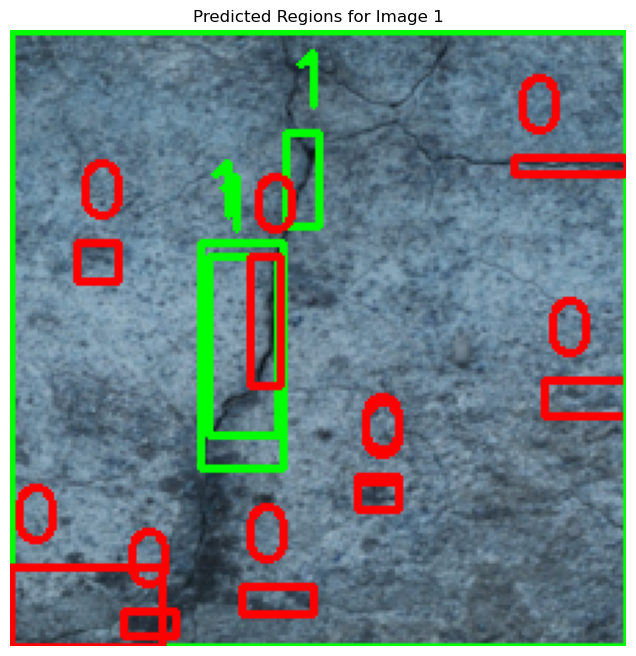

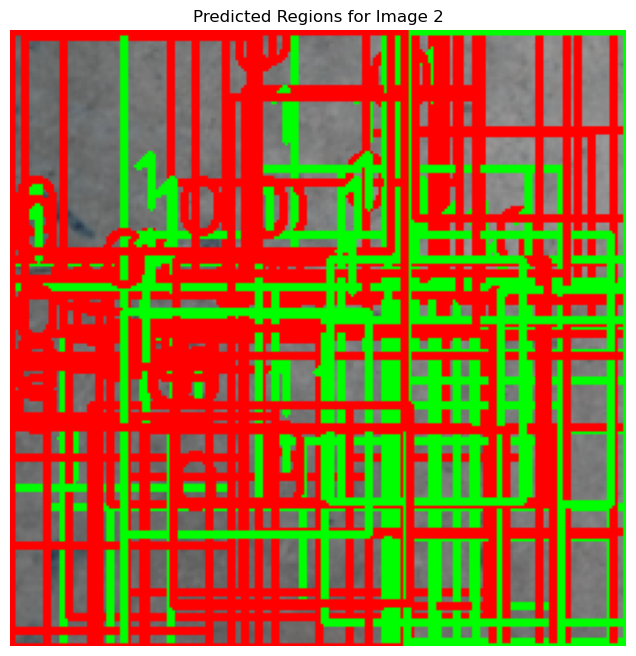

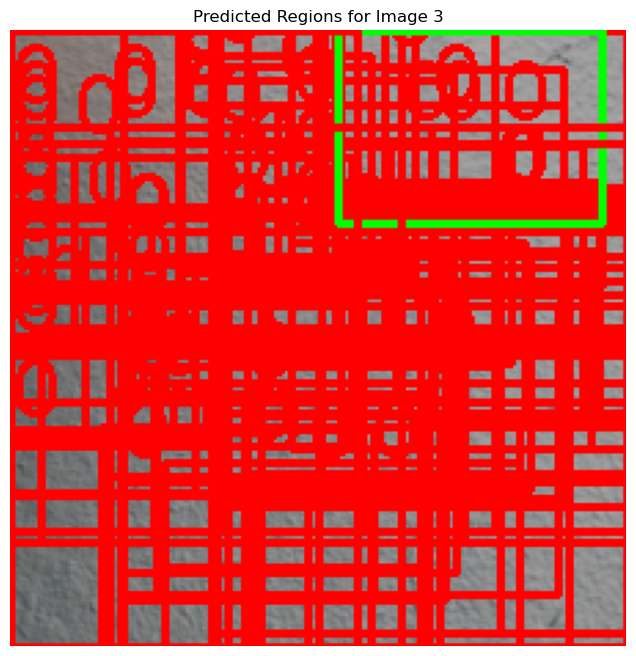

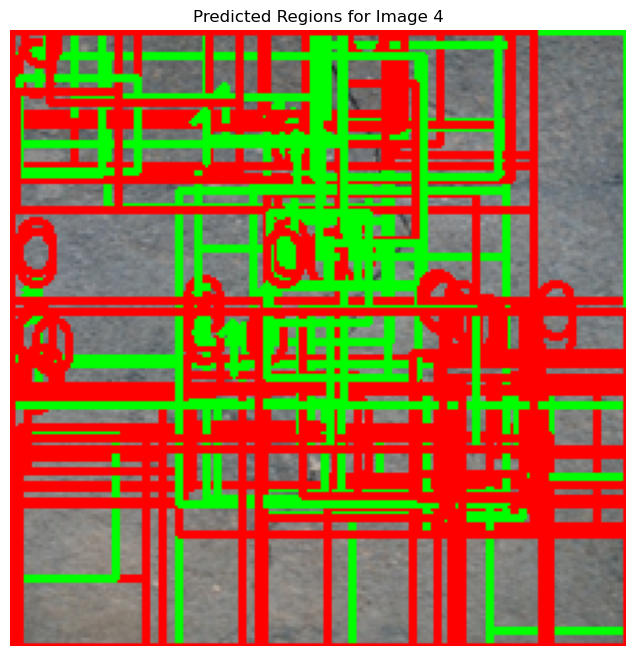

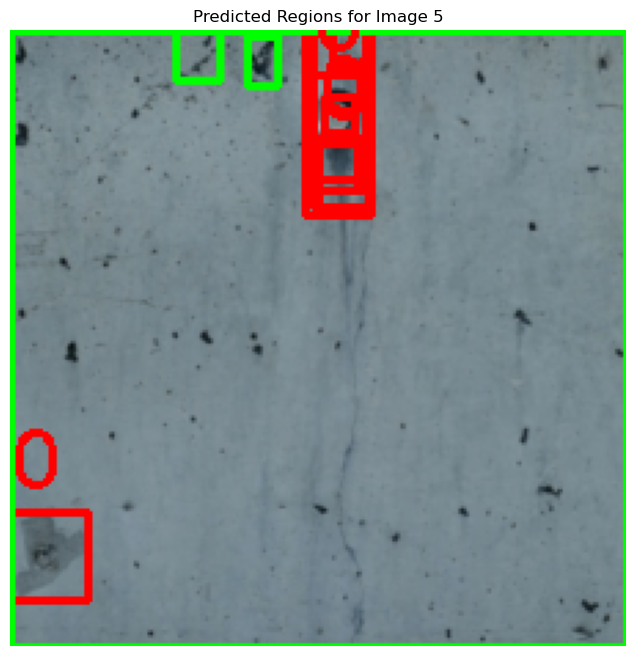

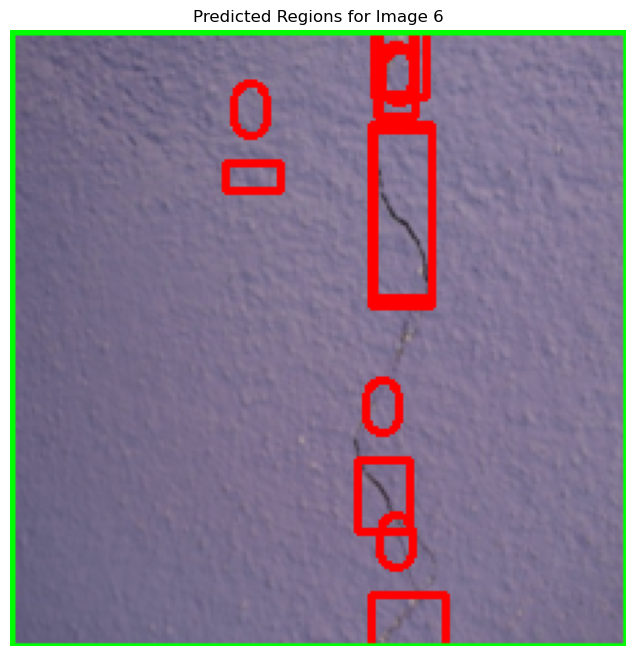

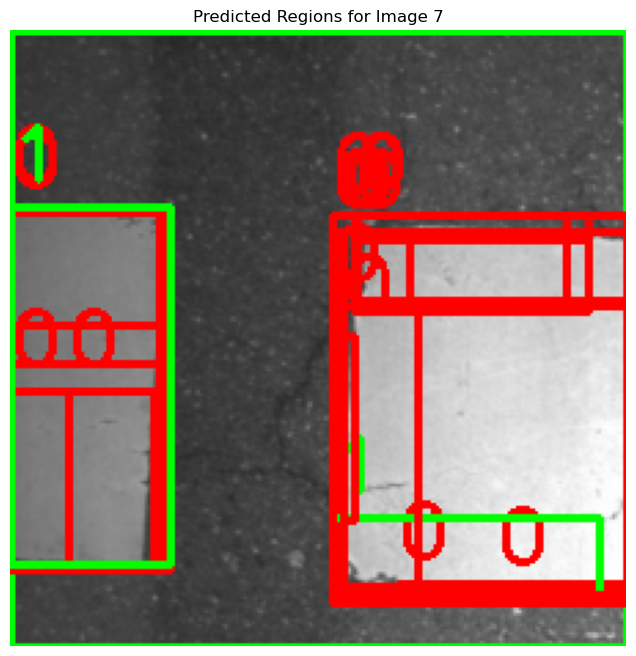

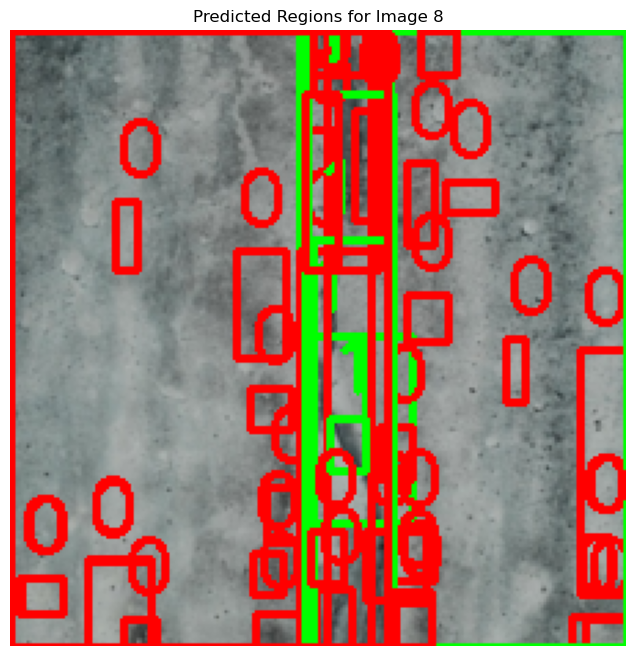

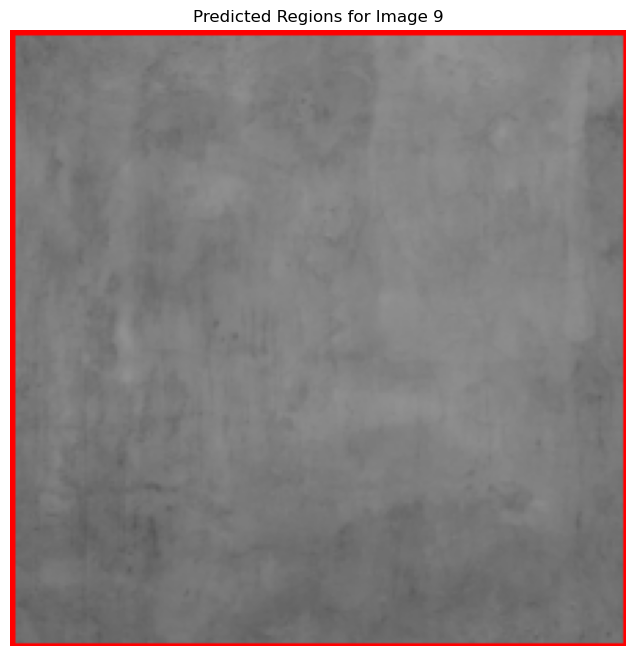

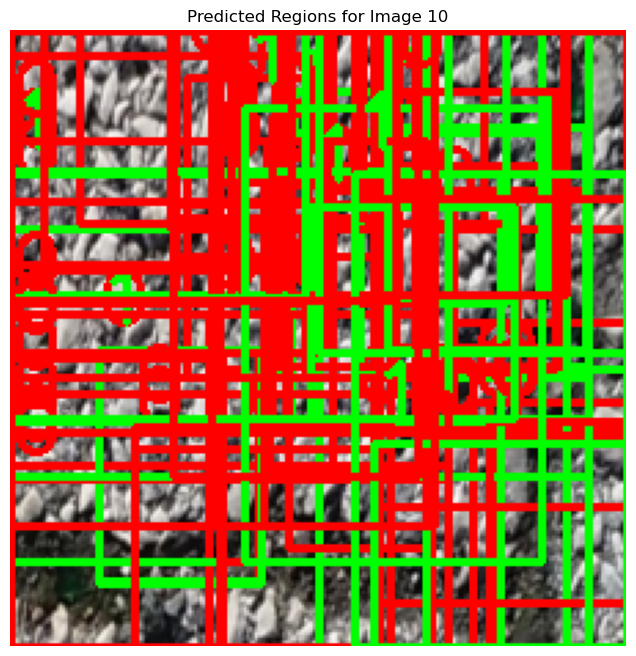

In [8]:
model.eval()
images_shown = 0
should_end = False

with torch.no_grad():
    for images_group, proposals_group, _ in valid_loader:
        if should_end:
            break
        
        for image, proposals in zip(images_group, proposals_group):
            if images_shown >= 10:
                should_end = True
                break

            image_np = image.permute(1, 2, 0).cpu().numpy()
            image_np = (image_np * 255).astype(np.uint8)
            image_with_boxes = image_np.copy()

            for proposal in proposals:
                x_min, y_min, x_max, y_max = proposal.int()
                x_min = x_min.item()
                y_min = y_min.item()
                x_max = x_max.item()
                y_max = y_max.item()
                cropped_region = image[:, y_min:y_max, x_min:x_max].unsqueeze(0).to(device)
                prediction = model(cropped_region).cpu().squeeze()
                label = "1" if prediction > 0.5 else "0"
                color = (0, 255, 0) if label == "1" else (0, 0, 255)

                cv2.rectangle(image_with_boxes, (x_min, y_min), (x_max, y_max), color, 2)
                cv2.putText(image_with_boxes, label, (x_min, y_min - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

            plt.figure(figsize=(8, 8))
            plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
            plt.title(f"Predicted Regions for Image {images_shown+1}")
            plt.axis('off')
            plt.show()

            images_shown += 1